## Transformer Segmentation for Autonomous Driving
`Team:CV1-15`
### Deep Learning for Computer Vision Software Lab Part 2 (Option 1) Software Lab
---

####   1. Download the data. 
> It is provided in *driving_train_data.h5* and *driving_test_data.h5.* Implement a data loader class to handle the downloaded data. For more information on the dataset please refer to: [CityScapes dataset](https://www.cityscapes-dataset.com/)

In [7]:
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch
import h5py
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
import numpy as np
from tqdm import tqdm
traindata = h5py.File("./option1_driving-segmentation/driving_train_data.h5")
testdata = h5py.File("./option1_driving-segmentation/driving_test_data.h5")
#train_loader = data.DataLoader(dataset=trainset, batch_size=16, shuffle=True, pin_memory=True)


In [2]:
"""
refer to: https://blog.csdn.net/sinat_35779431/article/details/116991936
"""

class MyDataset(data.Dataset):
    def __init__(self, archive,image='rgb',mask='seg',transform = None):
        super().__init__()
        self.archive = h5py.File(archive, 'r')
        self.data = self.archive[image]
        self.labels = self.archive[mask]
        self.transform = transform
    def __getitem__(self, index):
        image = self.data[index]
        mask = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
            mask = torch.LongTensor(mask)
        return image, mask

    def __len__(self):
        return len(self.labels)

    # def get_multi_class_labels(self,truth, n_labels=3, labels=(0, 1, 2)):
    #     new_shape =  [n_labels, ]+list(truth.shape[1:])
    #     y = np.zeros(new_shape, np.int8)
    #     for label_index in range(n_labels):
    #         if labels is not None:
    #             y[label_index, :, :][truth[0, :, :] == labels[label_index]] = 1
    #         else:
    #             y[label_index, :, :][truth[0, :, :] == label_index] = 1
    #     return y

    def close(self):
        self.archive.close()


In [3]:
rgb = traindata["rgb"]
seg = traindata["seg"]
train_dataset = MyDataset("./option1_driving-segmentation/driving_train_data.h5",transform=ToTensor())
# data = data.ConcatDataset([rgb,seg])
test_dataset = MyDataset("./option1_driving-segmentation/driving_test_data.h5",transform=ToTensor())
train_loader = data.DataLoader(dataset=train_dataset,batch_size=16,drop_last=True,shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=16,drop_last=True,shuffle=True)

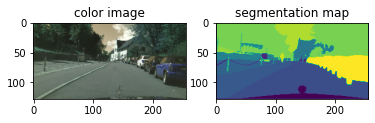

In [4]:
# show train images
plt.figure()
plt.subplot(1,2,1)
plt.imshow(rgb[0])
plt.title('color image')
plt.subplot(1,2,2)
plt.imshow(seg[0])
plt.title('segmentation map')
plt.show()

####   2. Define the model.
> Origin code from [CSDN](https://blog.csdn.net/weixin_44510615/article/details/119765864)

In [5]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512,padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512,padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        # print("encode1 output:",encode_pool1.shape)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        # print("encode2 output:",encode_pool2.shape)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # print("encode3 output:",encode_pool3.shape)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # print("bottleneck1 output:",bottleneck1.shape)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        # print("decoder3 output:",decode_block3.shape)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        # print("decoder2 output:",decode_block2.shape)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        # print("decoder1 output:",decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        # print("final output:",final_layer.shape)
        return  final_layer


In [6]:
# Visualizing the Model
unet = UNet(in_channel=3,out_channel=30)
unet

UNet(
  (conv_encode1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode

#### 3. Define the loss function and optimizer. 

In [7]:
#unet = UNet(in_channel=3,out_channel=30)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
# input = torch.permute(torch.tensor(rgb[0][None],dtype=torch.float),(0,3,1,2))
# label = torch.tensor(seg[0],dtype = torch.long).permute(2,0,1)
input = torch.permute(torch.tensor(rgb[0][None],dtype=torch.float),(0,3,1,2))
label = torch.tensor(seg[0],dtype = torch.long).permute(2,0,1)
outputs = unet(input)
m = outputs.shape[0]
loss = criterion(outputs, label)
loss.backward()
optimizer.step()
input.shape,label.shape


(torch.Size([1, 3, 128, 256]), torch.Size([1, 128, 256]))

#### 4. Train the network

In [8]:
unet = UNet(in_channel=3,out_channel=34)
device = "cuda:0"
unet.to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
num_epoch = 10
for i in range(num_epoch):   
    bar = tqdm(range(len(train_loader)))
    for j,(input,label) in enumerate(train_loader):
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        label = torch.permute(label,(3,0,1,2))[0]
        outputs = unet(input)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        bar.update()

  6%|▌         | 185/2975 [02:36<39:13,  1.19it/s]


In [9]:
# for j,(input,label) in enumerate(dataloader):
#     print("input shape",input.shape)
#     print("label shape",label.shape)
#     # input = torch.permute(input,(0,3,1,2))
#     label = torch.permute(label,(3,0,1,2))[0]
#     print("input shape",input.shape)
#     print("label shape",label.shape,label.dtype)
#     outputs = unet(input)
#     loss = criterion(outputs, label)
#     break

#### 5. Test the resulting network on examples from an independent test set.

Implement and present:  
    a. Create and save a bar chart showing the test accuracy across each semantic class.  
    b. Predictions and visualizations for (𝑖𝑛𝑝𝑢𝑡, µ, 𝑎𝑙𝑒𝑎𝑡𝑜𝑟𝑖𝑐, 𝑒𝑝𝑖𝑠𝑡𝑒𝑚𝑖𝑐) on 5 different input examples. Please save and visualize the results on each of the 5 different inputs. Since there are 4 visualizations per input, please provide a total of 5*4 = 20 images.  
    c. Comment briefly on how the model’s performance could be improved.  
    d. Please save your code and results for submission.  

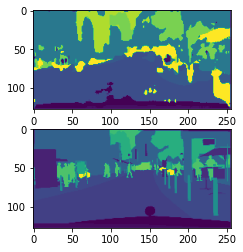

In [43]:
# Comparing the Results
unet.eval()
images, labels = test_dataset[0]
images = images[None]
labels = labels[None]
labels = torch.permute(labels,(3,0,1,2))[0]
images = images.to(device)

outputs = unet(images)
outputs = outputs.cpu()
_, predicted = torch.max(outputs, 1)
plt.subplot(211)
plt.imshow(predicted[0])
plt.subplot(212)
plt.imshow(labels[0])

In [34]:
"""
refer to https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py
and https://blog.csdn.net/sinat_29047129/article/details/103642140
"""

__all__ = ['SegmentationMetric']
 
"""
confusionMetric  # 此处横着代表预测值，竖着代表真实值，与之前介绍的相反
P\L     P    N
P      TP    FP
N      FN    TN
"""
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)
 
    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc
 
    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
        return classAcc # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率
 
    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
        return meanAcc # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89
 
    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix) 
        # 取对角元素的值，返回列表
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix) 
        # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
        IoU = intersection / union  
        # 返回列表，其值为各个类别的IoU
        mIoU = np.nanmean(IoU) 
        # 求各类别IoU的平均
        return mIoU
 
    def genConfusionMatrix(self, imgPredict, imgLabel): # 同FCN中score.py的fast_hist()函数
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix
 
    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU
 
 
    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)
 
    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))
 
 
imgPredict = predicted # 可直接换成预测图片
imgLabel = labels # 可直接换成标注图片
metric = SegmentationMetric(34) # 3表示有3个分类，有几个分类就填几
metric.addBatch(imgPredict, imgLabel)
pa = metric.pixelAccuracy()
cpa = metric.classPixelAccuracy()
mpa = metric.meanPixelAccuracy()
mIoU = metric.meanIntersectionOverUnion()
print('pa is : %f' % pa)
print('cpa is :') # 列表
print(cpa)
print('mpa is : %f' % mpa)
print('mIoU is : %f' % mIoU)


pa is : 0.729506
cpa is :
[0.         0.59761723 0.34469569 0.98913924 0.         0.
 0.         0.94105217 0.53007761 0.         0.         0.81295592
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93989491 0.35256321 0.93070958
 0.01168224 0.         0.73287228 0.         0.         0.
 0.         0.         0.         0.        ]
mpa is : 0.211272
mIoU is : 0.165507
